In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from pandas.plotting import scatter_matrix

In [40]:
#Read in datasets
df=pd.read_sas("/Users/alexmaillis/Downloads/P_DEMO.xpt")
huq=pd.read_sas("/Users/alexmaillis/Downloads/P_HUQ.xpt")
bmi=pd.read_sas("/Users/alexmaillis/Downloads/P_BMX.xpt")
diabetes=pd.read_sas("/Users/alexmaillis/Downloads/P_DIQ.xpt")
fitness=pd.read_sas("/Users/alexmaillis/Downloads/P_PAQ.xpt")
glu=pd.read_sas("/Users/alexmaillis/Downloads/P_GLU.xpt")
#checking that data imported 
glu.head(5)

,SEQN,WTSAFPRP,LBXGLU,LBDGLUSI
0,109264.00,27533.17,97.00,5.38
1,109271.00,18100.97,103.00,5.72
2,109274.00,16281.76,154.00,8.55
3,109277.00,32230.05,92.00,5.11
4,109282.00,79007.10,95.00,5.27


In [41]:
#1) renaming columns 
df=df.rename(columns={"SEQN":"ID","RIAGENDR":"gender","RIDAGEYR":"age_yrs","DMDMARTZ":"married_cat","DMDEDUC2":"edu_cat"})
huq=huq.rename(columns={"SEQN":"ID","HUQ010":"health_cond","HUQ051":"visits_per_yr","HUQ071":"IP_within_yr"})
bmi=bmi.rename(columns={"SEQN":"ID"})
fitness=fitness.rename(columns={"SEQN":"ID","PAD680":"min_sedentary","PAQ640":"days_walk"})
glu=glu.rename(columns={"SEQN":"ID","LBXGLU":"fasting_glu"})
df_y=diabetes.rename(columns={"SEQN":"ID","DIQ010":"y0_dm_doctor","DIQ050":"y1_dm_insulin","DIQ280":"y2_dm_a1c"})
#2) convert variables in scientific notation to integers
pd.set_option('display.float_format', '{:.2f}'.format)
# 3) check  
huq.head(10)

,ID,health_cond,HUQ030,visits_per_yr,HUD062,IP_within_yr,HUQ090
0,109263.00,1.00,1.00,1.00,NaN,2.00,NaN
1,109264.00,2.00,1.00,0.00,2.00,2.00,1.00
2,109265.00,1.00,1.00,2.00,NaN,2.00,NaN
3,109266.00,3.00,1.00,1.00,NaN,2.00,2.00
4,109267.00,1.00,2.00,1.00,NaN,2.00,2.00
5,109268.00,3.00,2.00,0.00,1.00,2.00,2.00
6,109269.00,1.00,1.00,4.00,NaN,2.00,NaN
7,109270.00,2.00,1.00,4.00,NaN,2.00,2.00
8,109271.00,4.00,1.00,2.00,NaN,2.00,2.00
9,109272.00,1.00,1.00,2.00,NaN,1.00,NaN


In [57]:
#Join datasets by ID 
df_1=df.set_index('ID').join(huq.set_index('ID'), on="ID",how="left").join(df_y.set_index('ID'), on="ID",how="left").join(bmi.set_index('ID'),how="left").join(fitness.set_index('ID'),how="left").\
    join(glu.set_index('ID'), on="ID",how="left")
df_1.reset_index(inplace=True)
df_2 = df_1[['ID', 'gender','age_yrs','married_cat','edu_cat','BMXBMI','BMDBMIC','fasting_glu','min_sedentary','days_walk','health_cond','visits_per_yr','IP_within_yr'
            , 'y0_dm_doctor','y1_dm_insulin','y2_dm_a1c']]
df_2.head(10)

,ID,gender,age_yrs,married_cat,edu_cat,BMXBMI,BMDBMIC,fasting_glu,min_sedentary,days_walk,health_cond,visits_per_yr,IP_within_yr,y0_dm_doctor,y1_dm_insulin,y2_dm_a1c
0,109263.00,1.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,2.00,2.00,NaN,NaN
1,109264.00,2.00,13.00,NaN,NaN,17.60,2.00,97.00,NaN,NaN,2.00,0.00,2.00,2.00,NaN,NaN
2,109265.00,1.00,2.00,NaN,NaN,15.00,2.00,NaN,NaN,NaN,1.00,2.00,2.00,2.00,NaN,NaN
3,109266.00,2.00,29.00,3.00,5.00,37.80,NaN,NaN,480.00,NaN,3.00,1.00,2.00,2.00,NaN,NaN
4,109267.00,2.00,21.00,3.00,4.00,NaN,NaN,NaN,540.00,NaN,1.00,1.00,2.00,2.00,NaN,NaN
5,109268.00,2.00,18.00,NaN,NaN,NaN,NaN,NaN,540.00,NaN,3.00,0.00,2.00,2.00,NaN,NaN
6,109269.00,1.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,4.00,2.00,2.00,NaN,NaN
7,109270.00,2.00,11.00,NaN,NaN,30.90,4.00,NaN,NaN,NaN,2.00,4.00,2.00,2.00,NaN,NaN
8,109271.00,1.00,49.00,3.00,2.00,29.70,NaN,103.00,60.00,NaN,4.00,2.00,2.00,2.00,NaN,NaN
9,109272.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,2.00,1.00,NaN,NaN,NaN


In [30]:
#THE NEXT 3 CELLS CHECK DATA DISTRIBUTION AND MISSINGNESS

In [58]:
print(df_2.describe())
print(df_2.info())

             ID   gender  age_yrs  married_cat  edu_cat   BMXBMI  BMDBMIC  \
count  15560.00 15560.00 15560.00      9232.00  9232.00 13137.00  4749.00   
mean  117042.50     1.50    33.74         1.71     3.55    26.66     2.55   
std     4491.93     0.50    25.32         2.76     1.21     8.42     0.86   
min   109263.00     1.00     0.00         1.00     1.00    11.90     1.00   
25%   113152.75     1.00    10.00         1.00     3.00    20.40     2.00   
50%   117042.50     2.00    30.00         1.00     4.00    25.80     2.00   
75%   120932.25     2.00    56.00         2.00     4.00    31.40     3.00   
max   124822.00     2.00    80.00        99.00     9.00    92.30     4.00   

       fasting_glu  min_sedentary  days_walk  health_cond  visits_per_yr  \
count      4744.00        9676.00    2253.00     15560.00       15560.00   
mean        111.18         399.29       4.83         2.41           2.55   
std          36.31         806.46       5.23         1.11           5.23   
mi

In [59]:
print(pd.crosstab(df_2['age_yrs'], df_2['BMDBMIC']))
#BMI Category is only available for age_yrs < 20. will use numeric value in model 

BMDBMIC  1.00  2.00  3.00  4.00
age_yrs                        
2.00       12   250    49    29
3.00        9   173    44    31
4.00       11   181    42    38
5.00       10   184    43    48
6.00       12   162    41    46
7.00        9   179    35    53
8.00       11   177    44    71
9.00        7   184    53    61
10.00      10   177    51    78
11.00       8   165    49    87
12.00       7   124    43    59
13.00       9   130    41    59
14.00       5   129    59    73
15.00       3   116    34    58
16.00       6   137    40    49
17.00      10   133    35    64
18.00      13   119    28    53
19.00      11    94    36    48


(array([ 692., 2295., 1350., 2163., 1416.,  226.,  775.,  453.,   87.,
        119.,   20.,    3.,    8.,    3.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    6.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         60.]), array([5.39760535e-79, 9.99900000e+01, 1.99980000e+02, 2.99970000e+02,
       3.99960000e+02, 4.99950000e+02, 5.99940000e+02, 6.99930000e+02,
       7.99920000e+02, 8.99910000e+02, 9.99900000e+02, 1.09989000e+03,


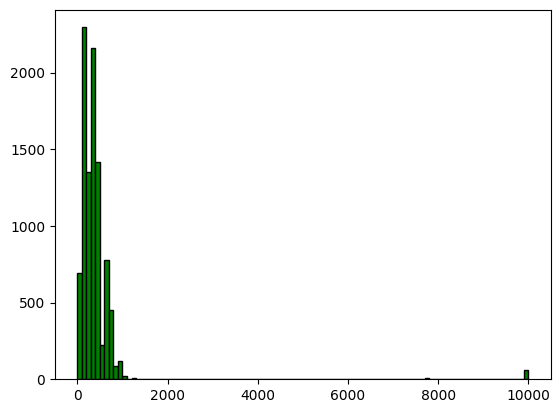

In [45]:
#%matplotlib inline
#df_2.hist(bins=60, figsize=(20,15))
#plt.show()

data=df_2.visits_per_yr
data1=df_2.BMXBMI
data2=df_2.min_sedentary
#print(plt.hist(data, bins=60,color='red',edgecolor='black'))
#print(plt.hist(data1, bins=60,color='blue',edgecolor='black'))
print(plt.hist(data2, bins=100,color='green',edgecolor='black'))

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.62x0.77)


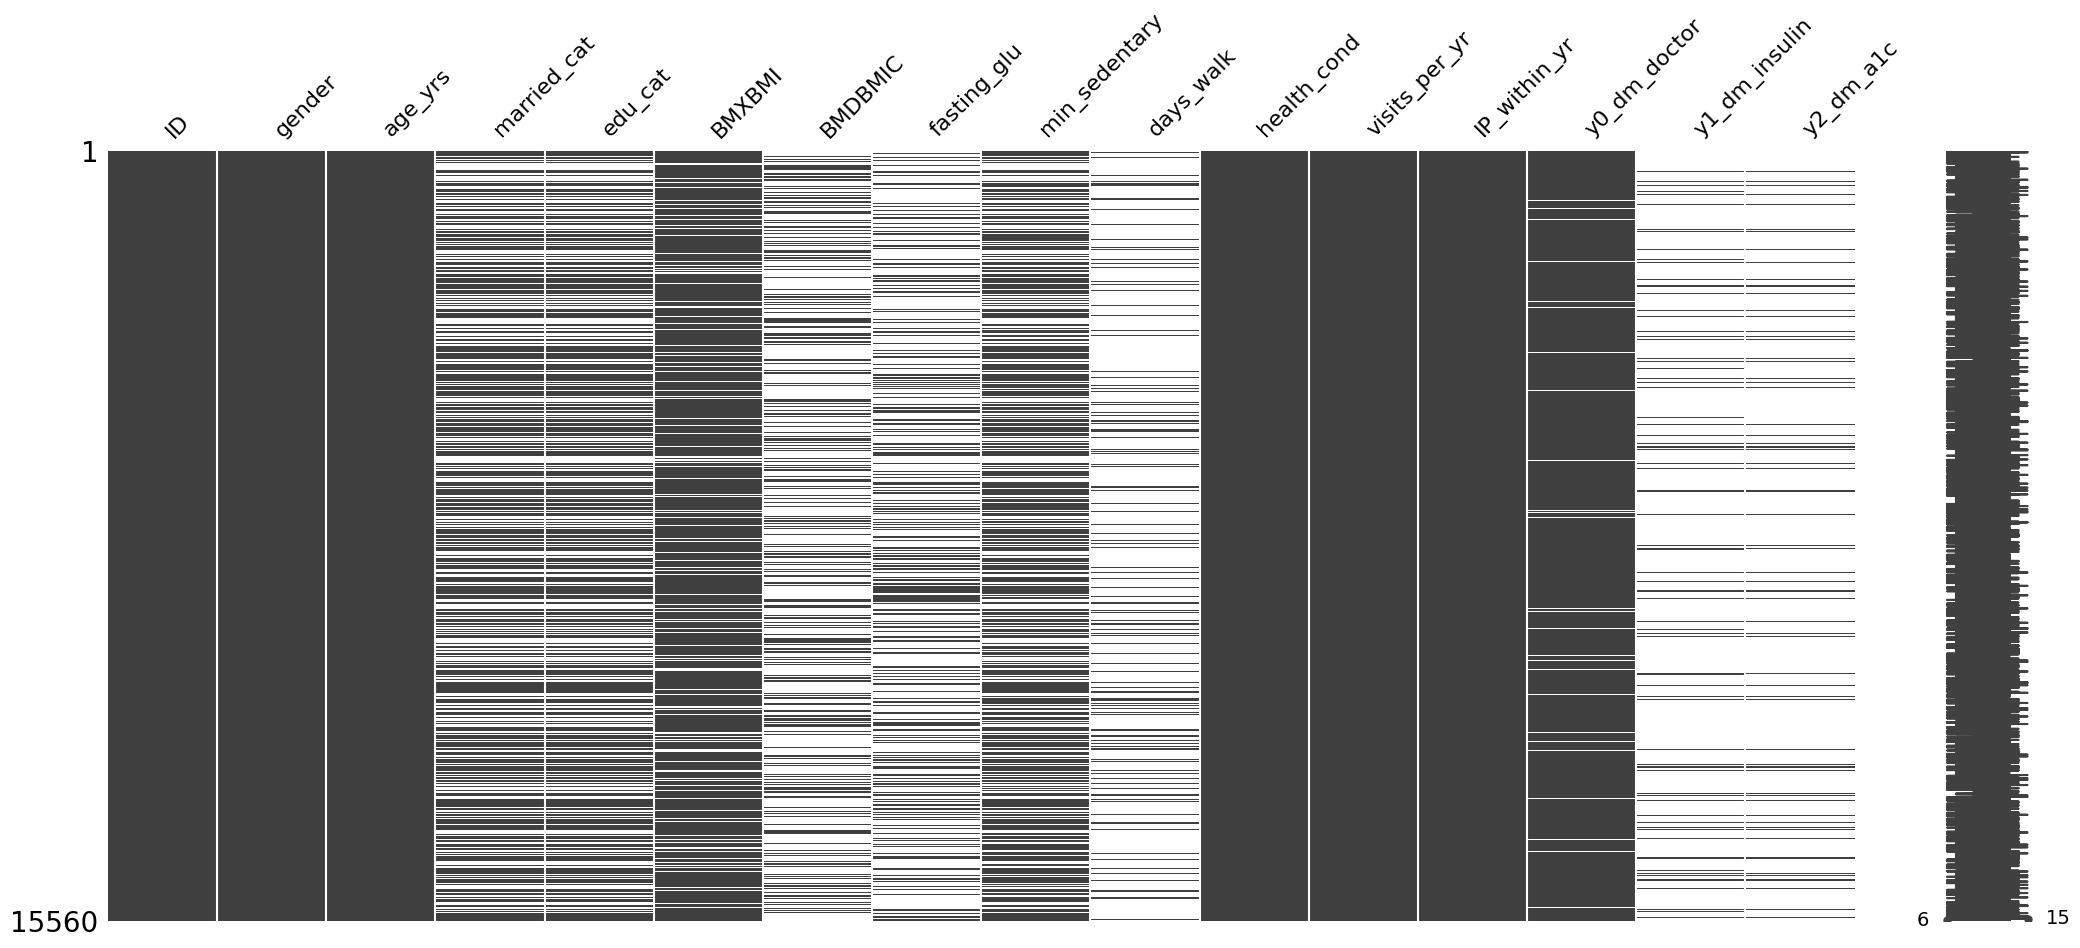

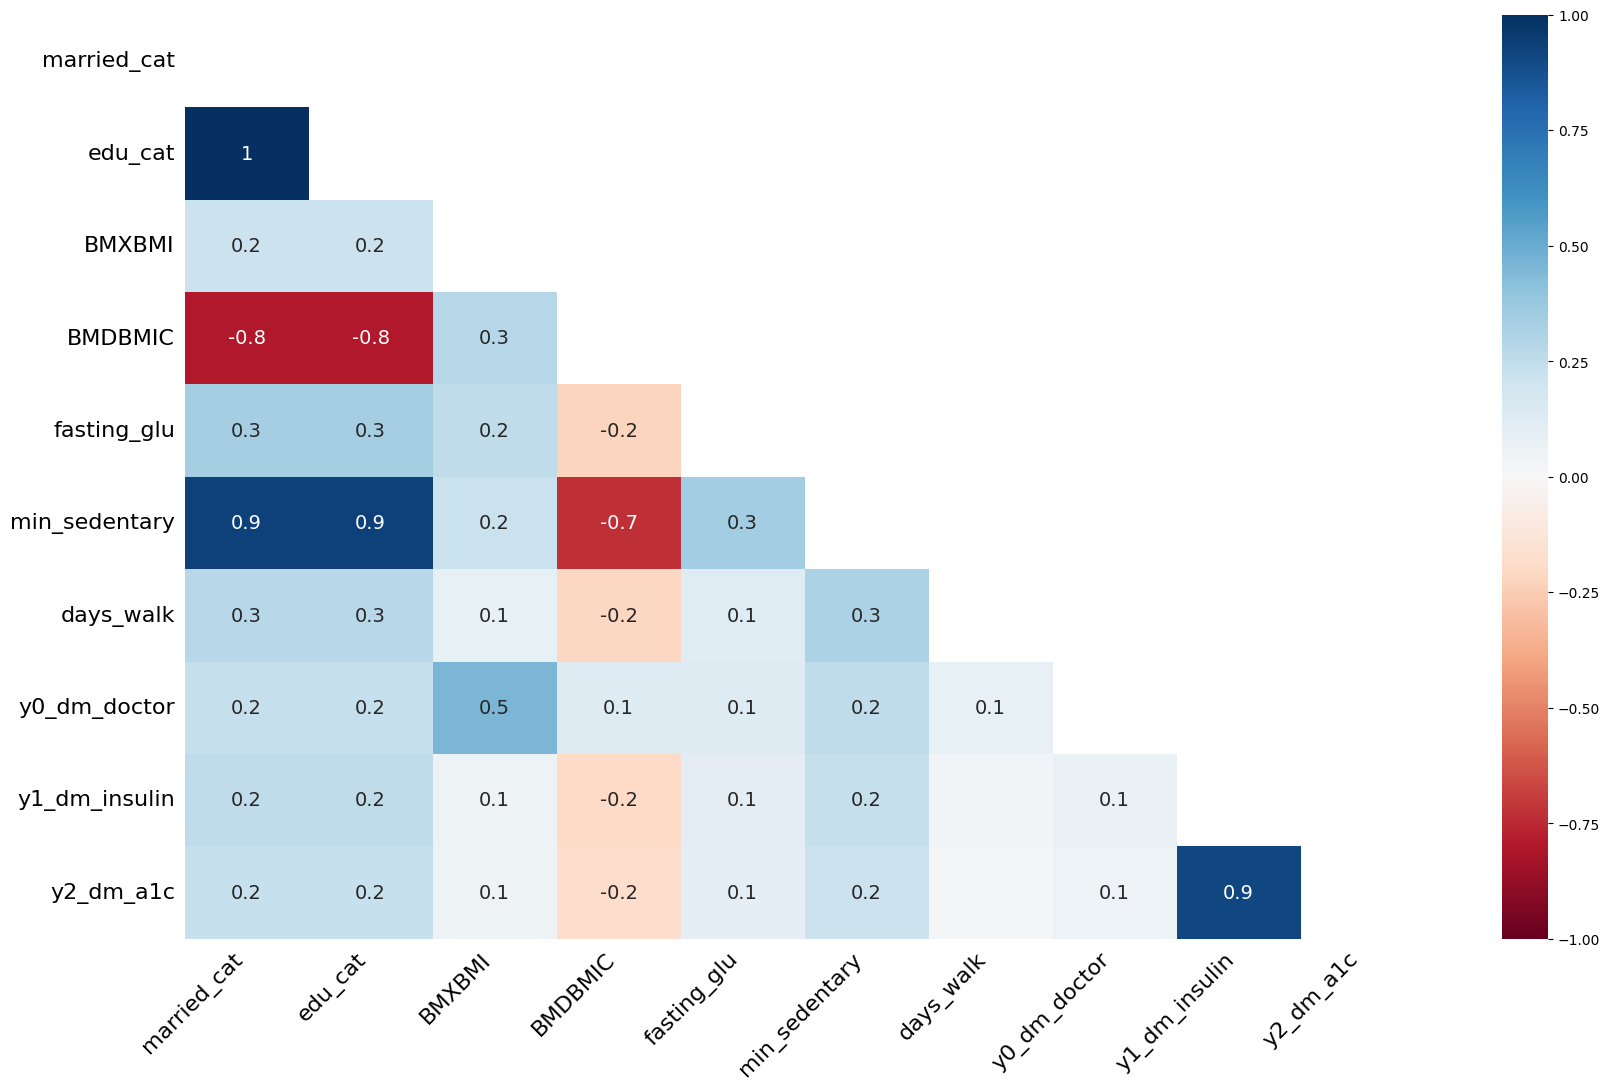

In [60]:
print(msno.matrix(df_2))
#print(msno.bar(df_2))
print(msno.heatmap(df_2))

In [63]:
#Clean Outcome variable and remove 'unknown'/'refused' observations
# Filter out rows with incomplete visit # and min_sedentary data
remove=[99.00]
remove1=[9999.0,7777.0]
df_3 = df_2[~df_2['visits_per_yr'].isin(remove)].copy()
df_4 = df_3[~df_3['min_sedentary'].isin(remove1)].copy()
df_5 = df_4[df_4['age_yrs'] > 17].copy()
#recode diabetes to 0/1
df_5['y0_dm_bin'] = df_5['y0_dm_doctor'].apply(lambda x: 1 if x == 1.00 else 0)

#check binary variable accuracy
print(pd.crosstab(df_5['y0_dm_bin'], df_5['y0_dm_doctor']))

df_6 = df_5[['gender','age_yrs','BMXBMI','min_sedentary','health_cond','visits_per_yr','IP_within_yr','y0_dm_bin']]
df_6 = df_6.dropna()
print(df_6.describe())

y0_dm_doctor  1.00  2.00  3.00  9.00
y0_dm_bin                           
0                0  7935   263     5
1             1404     0     0     0
       gender  age_yrs  BMXBMI  min_sedentary  health_cond  visits_per_yr  \
count 8701.00  8701.00 8701.00        8701.00      8701.00        8701.00   
mean     1.51    49.26   29.88         333.57         2.78           2.39   
std      0.50    18.36    7.61         202.38         1.03           1.98   
min      1.00    18.00   14.20           0.00         1.00           0.00   
25%      1.00    33.00   24.70         180.00         2.00           1.00   
50%      2.00    50.00   28.60         300.00         3.00           2.00   
75%      2.00    64.00   33.60         480.00         3.00           3.00   
max      2.00    80.00   92.30        1320.00         9.00           8.00   

       IP_within_yr  y0_dm_bin  
count       8701.00    8701.00  
mean           1.89       0.15  
std            0.34       0.35  
min            1.00       

In [64]:
#Check: stratified sampling vs random sampling? per CDC, 40% of americans are obese. Is my sample similar? 
print(len(df_6[df_6['BMXBMI'] >= 30.00]))
print(3647/8701)
#42% of data being included in model has BMI>=30.0 (obese). Will stick with random sampling vs. stratified

total_missing = df_6.isnull().sum().sum()

print(f"Total missing values in the DataFrame: {total_missing}")

3647
0.41914722445695896
Total missing values in the DataFrame: 0


In [65]:
#split data for testing
train_set, test_set = train_test_split(df_6,test_size=0.2,random_state=42)

#Check for multicollinearity in training data
print(train_set.corr())

#Split predictors from labels
dm_train=train_set.drop('y0_dm_bin',axis=1)
dm_labels=train_set['y0_dm_bin'].copy()

               gender  age_yrs  BMXBMI  min_sedentary  health_cond  \
gender           1.00    -0.02    0.08          -0.01         0.03   
age_yrs         -0.02     1.00    0.03           0.01         0.17   
BMXBMI           0.08     0.03    1.00           0.12         0.21   
min_sedentary   -0.01     0.01    0.12           1.00         0.01   
health_cond      0.03     0.17    0.21           0.01         1.00   
visits_per_yr    0.11     0.26    0.10           0.09         0.25   
IP_within_yr    -0.02    -0.13   -0.06          -0.05        -0.14   
y0_dm_bin       -0.05     0.29    0.16           0.04         0.25   

               visits_per_yr  IP_within_yr  y0_dm_bin  
gender                  0.11         -0.02      -0.05  
age_yrs                 0.26         -0.13       0.29  
BMXBMI                  0.10         -0.06       0.16  
min_sedentary           0.09         -0.05       0.04  
health_cond             0.25         -0.14       0.25  
visits_per_yr           1.00     

In [67]:
#Numeric and Categorical transformation pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
        
dm_num=dm_train[['age_yrs','BMXBMI','min_sedentary']]
dm_cat=dm_train[['gender','health_cond','visits_per_yr','IP_within_yr']]
num_attributes = list(dm_num)
cat_attributes = list(dm_cat)

num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler',StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

dm_processed=full_pipeline.fit_transform(dm_train)
dm_processed

<6960x24 sparse matrix of type '<class 'numpy.float64'>'
	with 48720 stored elements in Compressed Sparse Row format>

In [74]:
#TRAIN LOGISTIC MODEL 

log_reg=LogisticRegression()
log_reg.fit(dm_processed,dm_labels)
print("model score: %.3f" % log_reg.score(dm_processed,dm_labels))

model score: 0.857


In [76]:
#Now what? 